# **PHP 2650: Statistical Learning Final Project**

*Run all cells except training for testing purposes*

In [1]:
# Uncomment to download tensorflow
# pip install tensorflow

## **Sepsis Patient Simulation**

In [37]:
import numpy as np             # Lin. Alg. Purposes
import random                  # Generating Random Numbers
import tensorflow as tf        # Deep Learning Model
from collections import deque  # Deque is a list with a maximum size (used for DQN-Memory)


class SepsisSimulation:
    def __init__(self):
        self.start_diagnosis = random.randint(1, 4) # 0 for Stable, 1 for SIRS, 2 for Sepsis, 3 for Severe Sepsis, and 4 for Septic Shock
        self.patient = self.generate_patient()      # Set generates initial patient
        self.time_elapsed = 0
        self.is_alive = True

    def generate_patient(self):
        # Generate a random patient with different vital signs
        age = random.randint(18, 90)
        sex = random.choice(["male", "female"])
        is_infected = False
        temperature = round(random.uniform(37.5, 38.5), 1)
        heart_rate = random.randint(60, 120)
        respiratory_rate = random.randint(14, 18)
        systolic_bp = random.randint(90, 120)
        diastolic_bp = random.randint(60, 80)
        lactate = random.uniform(1, 2)
        oxygen_saturation = random.randint(95, 100)

        # Alter Diagnostics based on True Diagnosis
        if self.start_diagnosis == 2:
            # Sepsis
            is_infected = True
            temperature += random.uniform(0, 1.0)
            heart_rate += random.randint(5, 20)
            respiratory_rate += random.randint(1, 3)
            lactate += random.uniform(0.5, 1.0)
            systolic_bp -= random.randint(0, 5)
            diastolic_bp -= random.randint(0, 3)
            oxygen_saturation -= random.randint(0, 5)
            
        elif self.start_diagnosis == 3:
            # Severe Sepsis
            is_infected = True
            temperature += random.uniform(.5, 1.0)
            heart_rate += random.randint(10, 20)
            respiratory_rate += random.randint(2, 4)
            lactate += random.uniform(2.0, 3.0)
            systolic_bp -= random.randint(5, 10)
            diastolic_bp -= random.randint(0, 5)
            oxygen_saturation -= random.randint(1, 10)

        elif self.start_diagnosis == 4:
            # Septic Shock
            is_infected = True
            temperature += random.uniform(1.0, 2.0)
            heart_rate += random.randint(20, 40)
            respiratory_rate += random.randint(2, 4)
            systolic_bp -= random.randint(5, 15)
            diastolic_bp -= random.randint(0, 7)
            lactate += random.uniform(2.0, 4.0)
            oxygen_saturation -= random.randint(5, 15)

        # Alter Diagnostics based on Age
        if age > 60:
            systolic_bp += random.randint(0, 20)
            diastolic_bp += random.randint(0, 10)
            respiratory_rate += random.randint(0, 2)
            lactate += random.uniform(0.0, 1.0)

        # Returns a Dictionary with Patient Information
        patient = {
            "age": age,
            "sex": sex,
            "temperature": temperature,
            "heart_rate": heart_rate,
            "respiratory_rate": respiratory_rate,
            "systolic_bp": systolic_bp,
            "diastolic_bp": diastolic_bp,
            "lactate": lactate,
            "oxygen_saturation": oxygen_saturation,
            "is_infected": is_infected, 
            "diagnosis": self.start_diagnosis 
        }

        return patient
    
    def new_patient(self, start_diagnosis=None):
        # Simulate a New Patient
        self.start_diagnosis = start_diagnosis or random.randint(1, 4)
        self.patient = self.generate_patient()
        self.time_elapsed = 0
        self.is_alive = True
    
    def step(self, action, training=True):
        ### Update Vitals Based on Action Chosen ###

        # Antipyretic (acetaminophen or ibuprofen)
        if action == 0 and self.patient["temperature"] > 37.5:
            self.patient["temperature"] = max(37.5, self.patient["temperature"] - random.uniform(1, 2))

        # Antibiotics
        if action == 1:
            self.patient["is_infected"] = False

        # Fluids
        elif action == 2:
            if self.patient["diagnosis"] == 4:
                self.patient["systolic_bp"] += random.randint(5, 20)
                self.patient["diastolic_bp"] += random.randint(5, 15)
            else:
                self.patient["systolic_bp"] += random.randint(3, 7)
                self.patient["diastolic_bp"] += random.randint(1, 5)
            self.patient["respiratory_rate"] = max(12, self.patient["respiratory_rate"] - random.randint(1, 5))
            self.patient["lactate"] = max(0, self.patient["lactate"] - random.uniform(2, 3))
            self.patient["temperature"] = max(37.5, self.patient["temperature"] - random.uniform(0.1, 0.3))

        # Vasopressors
        elif action == 3:
            if self.patient["diagnosis"] == 4:
                self.patient["systolic_bp"] += random.randint(10, 20)
                self.patient["diastolic_bp"] += random.randint(5, 15)
            else:
                self.patient["systolic_bp"] += random.randint(5, 10)
                self.patient["diastolic_bp"] += random.randint(3, 7)
            self.patient["lactate"] = max(0, self.patient["lactate"] - random.uniform(1, 2))
            self.patient["oxygen_saturation"] = min(100, self.patient["oxygen_saturation"] + random.randint(1, 5))

        # Oxygen Therapy
        elif action == 4:
            self.patient["respiratory_rate"] = max(12, self.patient["respiratory_rate"] - random.randint(2, 4))
            self.patient["oxygen_saturation"] = min(100, self.patient["oxygen_saturation"] + random.randint(10, 15))


        ### Update Vitals and information for Round ###
        if self.patient["diagnosis"] == 1: # SIRS
            # Random Chance to Develop an infection during early stages of SIRS
            self.patient["is_infected"] = random.choices([True, False], [.25, .75])[0] and self.time_elapsed <= 6

            # Update Diagnosis 
            if self.patient["is_infected"]:
                self.patient["diagnosis"] = 2

            # Check if stable
            elif self.patient["systolic_bp"] >= 90 and self.patient["oxygen_saturation"] >= 95 and self.patient["respiratory_rate"] <= 16 \
                and self.patient["lactate"] < 2 and (36 < self.patient["temperature"] < 38):
                self.patient["diagnosis"] = 0

        elif self.patient["diagnosis"] == 2: # Sepsis
            # Update Vitals
            self.patient["systolic_bp"] -= random.randint(0, 10)
            self.patient["diastolic_bp"] -= random.randint(0, 7)
            self.patient["lactate"] += random.uniform(0, 1.5)
            self.patient["temperature"] += random.uniform(0, .1)
            self.patient["respiratory_rate"] += random.randint(0, 1)
            self.patient["heart_rate"] += random.randint(0, 5)

            # Update Diagnosis
            if not self.patient["is_infected"] and self.patient["oxygen_saturation"] >= 95:
                self.patient["diagnosis"] = 1

            elif self.patient["lactate"] >= 4 or self.patient["systolic_bp"] < 90:
                self.patient["diagnosis"] = 3

        elif self.patient["diagnosis"] == 3: # Severe Sepsis
            # Update Vitals
            self.patient["systolic_bp"] -= random.randint(0, 10)
            self.patient["diastolic_bp"] -= random.randint(0, 7)
            self.patient["lactate"] += random.uniform(0, 1.5)
            self.patient["temperature"] += random.uniform(0, .2)
            self.patient["respiratory_rate"] += random.randint(0, 3)
            self.patient["oxygen_saturation"] -= random.randint(1, 3)
            self.patient["heart_rate"] += random.randint(0, 10)

            # Update Diagnosis
            if self.patient["lactate"] < 4 and self.patient["systolic_bp"] >= 90 and self.patient["oxygen_saturation"] >= 90:
                self.patient["diagnosis"] = 2

            if self.patient["is_infected"] and self.patient["lactate"] >= 6:
                self.patient["diagnosis"] = 4
        
        elif self.patient["diagnosis"] == 4: # Septic Shock
            # Update Vitals
            self.patient["systolic_bp"] -= random.randint(0, 10)
            self.patient["diastolic_bp"] -= random.randint(0, 7)
            self.patient["lactate"] += random.uniform(0, 1.5)
            self.patient["temperature"] += random.uniform(0, .3)
            self.patient["respiratory_rate"] += random.randint(0, 3)
            self.patient["oxygen_saturation"] -= random.randint(1, 5)
            self.patient["heart_rate"] += random.randint(5, 10)

            # Update Diagnosis
            if self.patient["lactate"] < 6 and self.patient["systolic_bp"] > 80:
                self.patient["diagnosis"] = 3

        # Heart Rate Recovers over time
        self.patient["heart_rate"] = max(60, self.patient["heart_rate"] - random.randint(1,5))  
        
        # Increment time
        self.time_elapsed += 1

        ### Check if patient is alive ###
        if self.patient["systolic_bp"] < 70 or self.patient["systolic_bp"] > 180 or self.patient["oxygen_saturation"] < 70 or \
                self.patient["respiratory_rate"] > 25 or self.patient["lactate"] >= 8 or self.patient["temperature"] > 42 or \
                self.patient["temperature"] < 35 or self.patient['heart_rate'] > 220:
            self.is_alive = False

        # Past 12 hours mortality rate of Sepsis Very High for Simulation we assume Death
        elif self.patient["diagnosis"] >= 2 and self.time_elapsed >= 12:
            self.is_alive = False

        # Determine reward
        if self.is_alive and self.patient["diagnosis"] == 0:
            reward = 10
        elif not self.is_alive:
            reward = -10
        else:
            reward = -1

        # Determine if episode is done
        if training: # Maximum of 12 Steps can be taken during training
            done = not self.is_alive or self.patient["diagnosis"] == 0  or self.time_elapsed >= 12 
        else:
            done = not self.is_alive or self.patient["diagnosis"] == 0 

        return self.get_state(), reward, done


    def get_state(self):
        # Return patient state as a tensor (tensorflow formatted matrix)
        state = [
            self.patient["age"],
            1 if self.patient["sex"] == "male" else 0,
            self.patient["temperature"],
            self.patient["heart_rate"],
            self.patient["respiratory_rate"],
            self.patient["systolic_bp"],
            self.patient["diastolic_bp"],
            self.patient["lactate"],
            self.patient["oxygen_saturation"],
            1 if self.patient["is_infected"] else 0,
            self.patient["diagnosis"],
            self.time_elapsed
        ]
        return tf.reshape(tf.convert_to_tensor(state), (1,12))

## **Deep Q-Learning Network**

### **Creating Our Model**

In [2]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10_000)       # memory (deque is just a vector with maximum length)
        self.gamma = 0.99                        # discount rate
        self.epsilon = 1.0                       # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()         # Main Model
        self.target_model = self._build_model()  # Target Model
        self.update_target_model()

    def _build_model(self):
        # Neural Network for Deep-Q learning Model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(256, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy the weights from the main model to the target model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        # Adds info to memory deque
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon Greedy Algorithm
        if np.random.rand() <= self.epsilon: 
            return random.randrange(self.action_size)
        act_values = self.model(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        # Replay Algorithm for learning from batch_size number of past actions 
        minibatch = random.sample(self.memory, batch_size)

        # Initialize empty arrays to store the training data
        states = np.zeros((batch_size, self.state_size))
        targets = np.zeros((batch_size, self.action_size))

        # Fill in the training data
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.target_model(next_state)[0]))
            targets[i] = self.model(state).numpy()
            targets[i][action] = target

        # Use GradientTape to calculate the gradients and optimize the model parameters
        with tf.GradientTape() as tape:
            q_values = self.model(states)
            loss = tf.keras.losses.mean_squared_error(targets, q_values)
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            # Decrease epsilon as trainig goes on
            self.epsilon *= self.epsilon_decay

        if len(self.memory) % 50 == 0:
            # Every 50 Steps Set target model's weights to current model weights
            self.update_target_model()

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

### **Training**

In [ ]:
# initialize the environment
env = SepsisSimulation()
state_size = env.get_state().shape[1]  # 12 Inputs
action_size = 5                        # 5 Possible Outputs
batch_size = 64                        # Each Step Replay N Previous States

# Initialize Tracking tools
succ = 0
step_list = []

# Metric used to Graph Performance
total_reward = 0
reward_list = []
training_metrics = []

# initialize the deep Q-learning model
dqn_agent = DQN(state_size, action_size)

# run the game for a specified number of episodes
EPISODES = 1251
ROUND = 250

# Begin Trainning DQN
for e in range(EPISODES):
    # The environment generates a new patient and Gets the Beginning State
    env.new_patient()
    state = env.get_state()
    done = False
    # This loop runs until the episode is done
    while not done:
        action = dqn_agent.act(state)
        next_state, reward, done = env.step(action)
        dqn_agent.remember(state, action, reward, next_state, done)
        state = next_state
        if len(dqn_agent.memory) > batch_size: # If the memory > batch size, the agent learns from it
            dqn_agent.replay(batch_size)   

    # Metrics For Tracking During Training
    reward_list.append(reward)

    if reward > 0:
        succ += 1
    step_list.append(env.time_elapsed)

    if e % ROUND == 0 and e != 0:
        print("Episode: {}, % Stablized: {}, Avg Time Taken: {}".format(e, succ/ROUND, sum(step_list)/ROUND))
        training_metrics.append(np.mean(reward_list))
        reward_list = []  
        succ = 0
        step_list = []

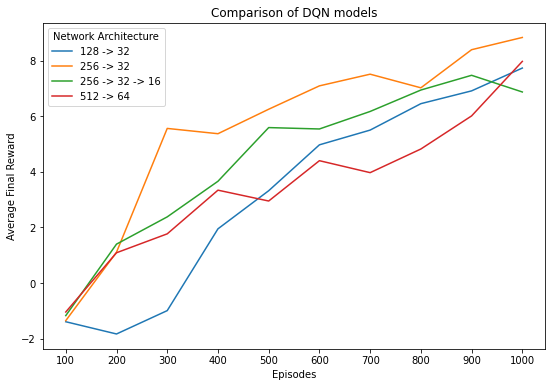

In [3]:
import matplotlib.pyplot as plt

# Stored Data from Previously Trained Models
model0_rewards = [-1.35, 1.11, 5.56, 5.37, 6.25, 7.09, 7.51, 7.02, 8.39, 8.83]
model1_rewards = [-1.04, 1.09, 1.77, 3.34, 2.95, 4.4, 3.97, 4.82, 6.01, 7.97]
model2_rewards = [-1.39, -1.83, -0.99, 1.95, 3.32, 4.97, 5.5, 6.45, 6.91, 7.73]
model3_rewards = [-1.17, 1.4, 2.38, 3.66, 5.59, 5.54, 6.17, 6.94, 7.47, 6.87]

# Adjusting figure size and layout
plt.figure(figsize=(9, 6)) # adjust the figure size in inches

# Plotting the lines
plt.plot(model2_rewards, label='128 -> 32')
plt.plot(model0_rewards, label='256 -> 32')
plt.plot(model3_rewards, label='256 -> 32 -> 16')
plt.plot(model1_rewards, label='512 -> 64')

# Adding axis labels and title
plt.xlabel('Episodes')
plt.ylabel('Average Final Reward')
plt.title('Comparison of DQN models')

x_ticks = list(range(0,10))
x_labels = list(range(100,1100,100)) # labels of the ticks
plt.xticks(x_ticks, x_labels)

# Adding legend with title
plt.legend(title='Network Architecture')

# Displaying the plot
plt.show()

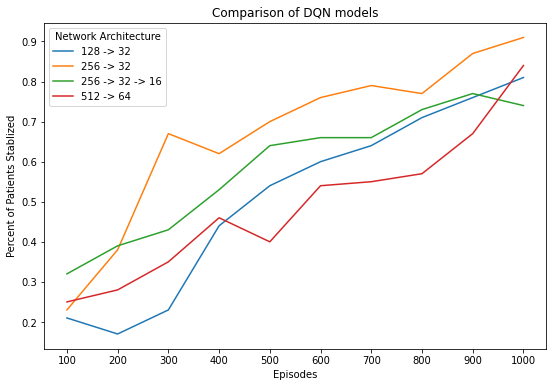

In [5]:
s_0 = [.23, .38, .67, .62, .7, .76, .79, .77, .87, .91]
s_1 = [.25, .28, .35, .46, .4, .54, .55, .57, .67, .84]
s_2 = [.21, .17, .23, .44, .54, .6, .64, .71, .76, .81]
s_3 = [.32, .39, .43, .53, .64, .66, .66, .73, .77, .74]

# Adjusting figure size and layout
plt.figure(figsize=(9, 6)) # adjust the figure size in inches

# Plotting the lines
plt.plot(s_2, label='128 -> 32')
plt.plot(s_0, label='256 -> 32')
plt.plot(s_3, label='256 -> 32 -> 16')
plt.plot(s_1, label='512 -> 64')

# Adding axis labels and title
plt.xlabel('Episodes')
plt.ylabel('Percent of Patients Stablized')
plt.title('Comparison of DQN models')

x_ticks = list(range(0,10))
x_labels = list(range(100,1100,100)) # labels of the ticks
plt.xticks(x_ticks, x_labels)

# Adding legend with title
plt.legend(title='Network Architecture')

# Displaying the plot
plt.show()

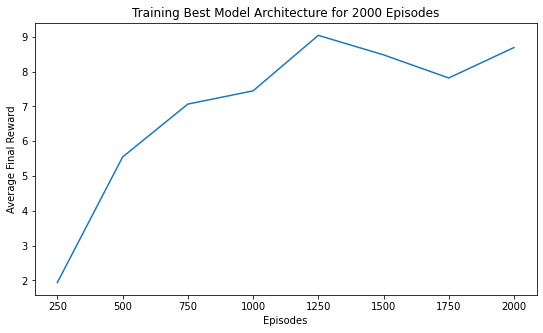

In [22]:
# Visualization for training model for 2k Episodes
twok_model = [1.94, 5.545, 7.065, 7.445, 9.04, 8.48, 7.815, 7.69]

# Adjusting figure size and layout
plt.figure(figsize=(9, 5)) # adjust the figure size in inches

# Plotting the lines
plt.plot(twok_model)

# Adding axis labels and title
plt.xlabel('Episodes')
plt.ylabel('Average Final Reward')
plt.title('Training Best Model Architecture for 2000 Episodes')

x_ticks = list(range(0,8))
x_labels = list(range(250,2250,250)) # labels of the ticks
plt.xticks(x_ticks, x_labels)

# Displaying the plot
plt.show()

### **Testing**

In [32]:
# For Testing the agent on mortality rates for each beginning diagnosis
def test_agent(a, stage=None):
    '''
    @param a: Agent
    @param stage: Patient's Beginning Stage of Sepsis
    '''
    r_list = []
    n_list = []

    # Runs simulation for 1000 patients and records end results
    for i in range(1000):
        e = SepsisSimulation()
        e.new_patient(stage)
        done = False
        while not done:
            st = e.get_state()
            q_values = a.model(st).numpy()
            action = np.argmax(q_values)
            next_state, reward, done = e.step(action, False)

        r_list.append(reward)
        n_list.append(e.time_elapsed)

    avg_steps = np.mean(n_list)
    num_stable = r_list.count(10) # Stable
    num_dead = r_list.count(-10)  # Dead
    
    return print(f'% Stabilized: {num_stable/1000} \n% Dead: {num_dead/1000} \nAvg # Steps: {avg_steps}')

In [ ]:
# Percent of Patients Stablized
test_agent(dqn_agent)

## **Playing Through the Simulation**

In [50]:
import time
from IPython.display import clear_output

# Dictionaries for Visualizing within play_sim
action_list = {0: 'Antipyretic', 1: 'Antibiotics', 2: 'Fluids', 3: 'Vasopressors', 4: 'Oxygen Therapy'}
outcome_list = {10: 'Stablized', -10: 'Death', -1: 'Unknown'}
stage_list = {0: 'Stable', 1: 'SIRS', 2: 'Sepsis', 3:'Severe Sepsis', 4:"Septic Shock"}

# For Visualizing the game states as our agent plays
def play_sim(a, stage=None, sleep_time=1):
    '''
    @param a: Agent
    @param stage: Patient's Beginning Stage of Sepsis
    @param sleep_time: Amount of time between Actions
    '''
    e = SepsisSimulation()
    e.new_patient(stage)
    done = False
    while not done:
        clear_output(wait=True)
        st = e.get_state()
        q_values = a.model(st).numpy()
        action = np.argmax(q_values)
        print("----------------------------------------------------")
        print("Diagnosis:",stage_list[e.patient['diagnosis']])
        print("Recommended Treatment:", action_list[action])
        next_state, reward, done = e.step(action, False)
        print("Updated Patient Info:\n")
        for k, v in e.patient.items():
            if k == 'diagnosis':
                print(f"{k.capitalize()}: {stage_list[v]}")
            else:
                print(f"{k.capitalize()}: {v}")
        print("----------------------------------------------------")
        print(f'Time Elapsed: {e.time_elapsed}')
        time.sleep(sleep_time)
        
    print(f"Patient Outcome: {outcome_list[reward]}")

In [4]:
# Generates Testing Environment and Loads in Pretrained Model
agent = DQN(12,5)
agent.load('Final_Model.h5')

In [57]:
###   RERUN CELL TO SIMULATE NEW PATIENTS   ###

# Generates New Patient
# Change value between 0-4 for what starting diagnosis you want to test
# Or leave blank for random generation

# Plays through simulation
play_sim(agent, 4)

----------------------------------------------------
Diagnosis: Severe Sepsis
Recommended Treatment: Vasopressors
Updated Patient Info:

Age: 30
Sex: female
Temperature: 40.22562987371651
Heart_rate: 181
Respiratory_rate: 22
Systolic_bp: 83
Diastolic_bp: 72
Lactate: 1.2558646270662979
Oxygen_saturation: 99
Is_infected: True
Diagnosis: Severe Sepsis
----------------------------------------------------
Time Elapsed: 12
Patient Outcome: Death
